## Regress out cell counts from all features on full dataset

In [2]:
import sys
sys.path.append('../1.load')

import numpy as np
import pandas as pd

from preprocess import preprocess_profiles, config
from correct_position_effect import subtract_well_mean, mad_robustize_col, regress_out_cell_counts

import seaborn as sns
from matplotlib import pyplot as plt

#### Load profiles

In [3]:
CC_COL = "Cells_Count"

In [3]:
ann_profiles = pd.read_parquet("../1.load/output/raw_filtered_profiles.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,82.875999,76.996002,77.473999,76.582001,77.233002,78.186996,80.055000,77.632004,79.955002,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,93.607002,88.196999,89.211998,88.081001,89.154999,89.897003,92.719002,89.843002,92.597000,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,133.380005,126.150002,127.250000,125.769997,127.250000,128.429993,131.880005,127.940002,131.960007,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,84.871002,80.910004,81.814003,80.850998,81.926003,82.567001,85.179001,82.646004,85.292999,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,91.669998,87.241997,87.132004,86.538002,87.476997,88.224998,90.223000,87.663002,90.227997,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84846,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,71.441002,66.777000,67.111000,66.614998,66.950996,67.466003,69.115997,67.341003,69.023003,2021_08_30_Batch13
84847,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,76.763000,72.568001,73.039001,72.873001,73.301003,73.550003,75.428001,73.696999,75.563004,2021_08_30_Batch13
84848,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,91.638000,86.575996,87.012001,86.803001,87.361000,87.459999,89.482002,87.972000,90.033997,2021_08_30_Batch13
84849,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,47.766998,45.113998,45.214001,45.137001,45.473999,45.556000,46.622002,45.544998,46.728001,2021_08_30_Batch13


In [4]:
ann_profiles.filter(regex="^(?!Metadata_)").isnull().any().any()

False

Text(0.016277023629964808, 5, '0.016')

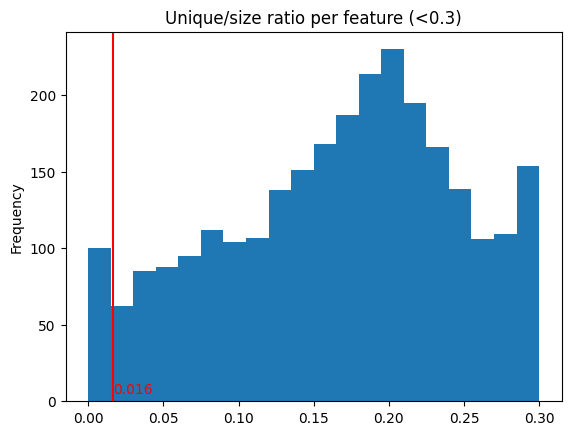

In [5]:
unique_ratio = ann_profiles.nunique() / ann_profiles.shape[0]
unique_ratio[unique_ratio<0.3].plot(kind="hist", bins=20, title="Unique/size ratio per feature (<0.3)")
plt.axvline(x=unique_ratio["Cells_Count"], color="red")
plt.text(unique_ratio["Cells_Count"], 5, f"{unique_ratio['Cells_Count']:.3f}", color="red")

#### Explore correlations with cell counts

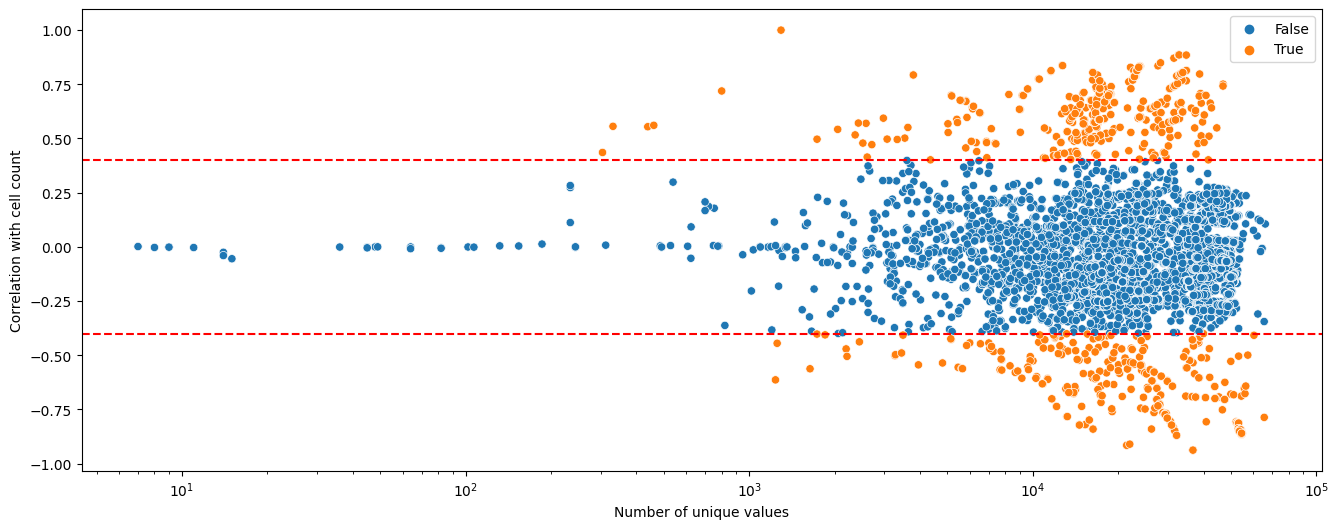

In [6]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6)) 
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    hue=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]).abs() > corr_cutoff,
    )
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")

plt.xscale("log")

plt.axhline(y=corr_cutoff, color="red", linestyle="--")
plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### List low unique ratio features that are correlated with cell count

No features that have nigh correlations and less than 1000 unique values

In [7]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if (feature_corr > corr_cutoff or feature_corr < -corr_cutoff) and ann_profiles[feature].nunique() < 1000:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Image_Threshold_SumOfEntropies_CellsIncludingEdges: 0.719204705093529
Nuclei_Correlation_Manders_AGP_RNA: 0.5543123213473639
Nuclei_Correlation_Manders_DNA_RNA: 0.4355270570234875
Nuclei_Correlation_Manders_ER_RNA: 0.5561504156643421
Nuclei_Correlation_Manders_Mito_RNA: 0.5608293614930626


#### Regress out cell counts only from features that have >100 unique values

In [8]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL, min_unique=100)
ann_profiles

  0%|          | 0/4762 [00:00<?, ?it/s]

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,8.363270,6.547332,6.488146,6.165048,6.141906,6.595287,6.543043,6.072807,6.353294,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,21.560386,20.099374,20.601901,20.014168,20.448187,20.707467,21.672341,20.684496,21.471937,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,59.376581,56.186873,56.754792,55.838394,56.651311,57.334384,58.877185,56.876600,58.869780,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,11.859385,11.892405,12.274262,11.864552,12.286210,12.437484,13.167659,12.548097,13.198814,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,17.639769,17.253313,16.610972,16.580855,16.852392,17.103280,17.193383,16.573505,17.110850,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84846,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.712837,-1.422843,-1.602391,-1.554015,-1.859480,-1.827975,-2.037851,-1.921880,-2.209741,2021_08_30_Batch13
84847,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,4.984440,4.725925,4.687139,5.061615,4.853353,4.621572,4.649307,4.799437,4.707141,2021_08_30_Batch13
84848,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,20.851246,19.679450,19.615606,19.936772,19.872247,19.497659,19.694786,20.039934,20.174176,2021_08_30_Batch13
84849,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-22.885728,-21.654774,-22.053278,-21.601504,-21.885173,-22.275787,-23.031231,-22.256595,-22.997220,2021_08_30_Batch13


In [9]:
ann_profiles.to_parquet("output/profiles_cc_adjusted.parquet")

#### Check if cell count has correlation above 0.5 with any feature

In [10]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if np.abs(feature_corr) > 0.5:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Cells_Count: 1.0


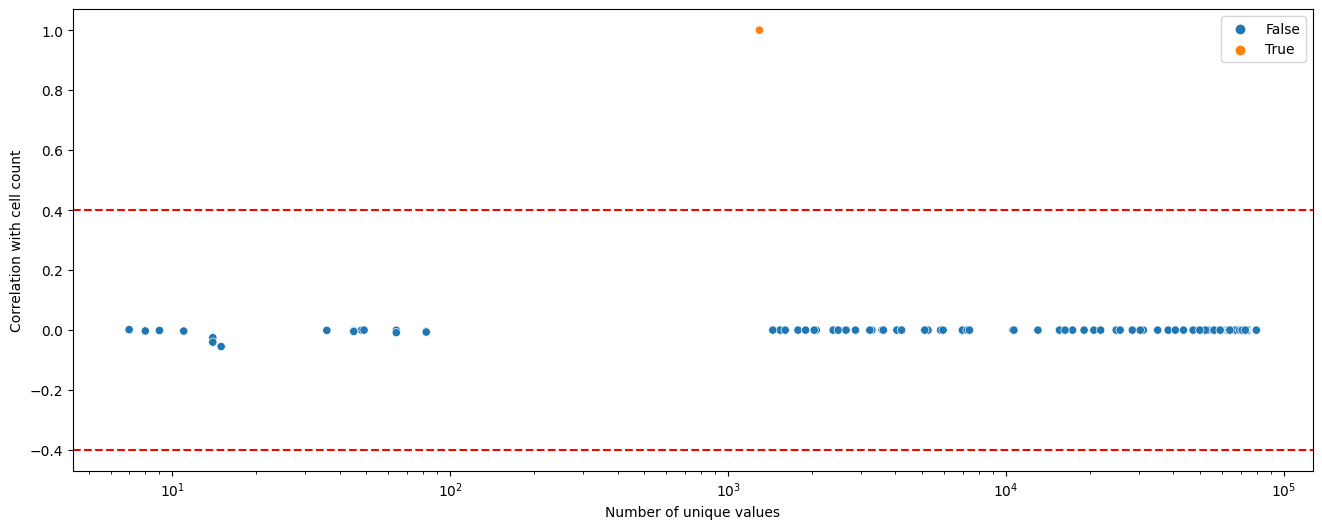

In [11]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6)) 
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    hue=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]).abs() > corr_cutoff,
    )
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")

plt.xscale("log")


plt.axhline(y=corr_cutoff, color="red", linestyle="--")
plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### Plot the ratio of unique values / size for cell count

This is the reason it gets filtered by `feature_select`

Text(0.016277023629964808, 5, '0.016')

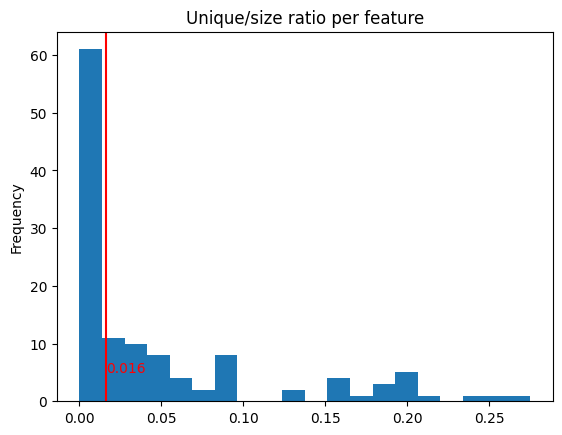

In [12]:
unique_ratio = ann_profiles.nunique() / ann_profiles.shape[0]
unique_ratio[unique_ratio<0.3].plot(kind="hist", bins=20, title="Unique/size ratio per feature")
plt.axvline(x=unique_ratio["Cells_Count"], color="red")
plt.text(unique_ratio["Cells_Count"], 5, f"{unique_ratio['Cells_Count']:.3f}", color="red")

#### Preprocess and save CC-corrected subset

In [4]:
ann_profiles = pd.read_parquet("output/profiles_cc_adjusted.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,8.363270,6.547332,6.488146,6.165048,6.141906,6.595287,6.543043,6.072807,6.353294,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,21.560386,20.099374,20.601901,20.014168,20.448187,20.707467,21.672341,20.684496,21.471937,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,59.376581,56.186873,56.754792,55.838394,56.651311,57.334384,58.877185,56.876600,58.869780,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,11.859385,11.892405,12.274262,11.864552,12.286210,12.437484,13.167659,12.548097,13.198814,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,17.639769,17.253313,16.610972,16.580855,16.852392,17.103280,17.193383,16.573505,17.110850,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.712837,-1.422843,-1.602391,-1.554015,-1.859480,-1.827975,-2.037851,-1.921880,-2.209741,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,4.984440,4.725925,4.687139,5.061615,4.853353,4.621572,4.649307,4.799437,4.707141,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,20.851246,19.679450,19.615606,19.936772,19.872247,19.497659,19.694786,20.039934,20.174176,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-22.885728,-21.654774,-22.053278,-21.601504,-21.885173,-22.275787,-23.031231,-22.256595,-22.997220,2021_08_30_Batch13


In [5]:
ann_profiles = preprocess_profiles(ann_profiles) 
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_00_256,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_SumVariance_AGP_5_00_256
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,0.154119,0.156723,0.010916,0.098341,0.190058,0.461289,-0.083514,0.118963,-0.025048,0.681567
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,1.449770,1.330318,0.268875,-0.174386,-0.030645,0.622603,-0.586738,-0.615445,0.395099,0.022863
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,-0.506943,-1.352286,0.272147,-0.323143,-0.460776,-0.207175,-1.259340,0.699973,0.651841,2.342113
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,0.039485,0.015037,0.263873,0.020122,-0.027618,0.346049,-0.416379,0.409459,0.336837,0.443924
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,-0.655679,-0.830630,0.293647,-0.187340,-0.170085,-0.320438,-0.164595,0.687811,0.059703,1.996435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.381467,-1.239409,-2.251799,-0.401542,-0.589179,-1.345575,0.177495,1.330154,0.932187,0.431965
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.437218,-1.589954,-2.119237,-0.281263,-0.565139,-0.794488,0.364668,1.672849,0.968528,0.941279
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.202359,-1.588996,-1.344980,-0.324372,-0.953851,-1.091168,-0.193064,1.763786,1.191848,1.530070
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.199208,-1.159388,-1.501242,0.008166,-0.277178,-1.425041,0.658577,1.179686,0.474178,0.465273


In [6]:
# check that the cell count column is still there
assert CC_COL in ann_profiles.columns

ann_profiles.to_parquet("output/profiles_cc_adjusted_preprocessed.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_00_256,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_SumVariance_AGP_5_00_256
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,0.154119,0.156723,0.010916,0.098341,0.190058,0.461289,-0.083514,0.118963,-0.025048,0.681567
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,1.449770,1.330318,0.268875,-0.174386,-0.030645,0.622603,-0.586738,-0.615445,0.395099,0.022863
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,-0.506943,-1.352286,0.272147,-0.323143,-0.460776,-0.207175,-1.259340,0.699973,0.651841,2.342113
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,0.039485,0.015037,0.263873,0.020122,-0.027618,0.346049,-0.416379,0.409459,0.336837,0.443924
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,-0.655679,-0.830630,0.293647,-0.187340,-0.170085,-0.320438,-0.164595,0.687811,0.059703,1.996435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.381467,-1.239409,-2.251799,-0.401542,-0.589179,-1.345575,0.177495,1.330154,0.932187,0.431965
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.437218,-1.589954,-2.119237,-0.281263,-0.565139,-0.794488,0.364668,1.672849,0.968528,0.941279
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.202359,-1.588996,-1.344980,-0.324372,-0.953851,-1.091168,-0.193064,1.763786,1.191848,1.530070
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.199208,-1.159388,-1.501242,0.008166,-0.277178,-1.425041,0.658577,1.179686,0.474178,0.465273
